In [ ]:
# Imports necesarios para el módulo
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
from torchvision import datasets, transforms
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
import time
# Importamos los métodos necesarios para el módulo
# Podeis ver el fichero 03_utils.py para ver el código de los métodos usados en esta celda
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from tqdm import tqdm
import time
try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab


In [ ]:
#configuro el dispositivo para usar la GPU si esta disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Leo el archivo CSV
df = pd.read_csv("/content/drive/MyDrive/DeepLearning/proyecto/poi_dataset.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os
#Ruta al archivo ZIP
zip_path = '/content/drive/MyDrive/DeepLearning/proyecto/data_main.zip'

#Carpeta donde se descomprimiran los archivos
data_main_path = '/content/drive/MyDrive/DeepLearning/proyecto/data_main/'

#Creo la carpeta de extraccion
os.makedirs(data_main_path, exist_ok = True)

#Descomprimir el archivo ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(data_main_path)

#Listar los archivos descomprimidos
extracted_files = os.listdir(data_main_path)
#for file in extracted_files:
#  print(file)

In [ ]:
df.head().T

,0,1,2,3,4
id,4b36a3ed-3b28-4bc7-b975-1d48b586db03,e32b3603-a94f-49df-8b31-92445a86377c,0123a69b-13ac-4b65-a5d5-71a95560cff5,390d7d9e-e972-451c-b5e4-f494af15e788,023fc1bf-a1cd-4b9f-af78-48792ab1a294
name,Galería Fran Reus,Convento de San Plácido,Instituto Geológico y Minero de España,Margarita Gil Roësset,Museo del Traje. Centro de Investigación del P...
shortDescription,La Galería Fran Reus es un espacio dedicado a ...,"El Convento de San Plácido en Madrid, fundado ...","El Instituto Geológico y Minero de España, sit...","Margarita Gil Roësset, escultora y poetisa esp...","El Museo del Traje de Madrid, fundado en 2004,..."
categories,"['Escultura', 'Pintura']","['Patrimonio', 'Historia']","['Ciencia', 'Patrimonio']",['Cultura'],"['Patrimonio', 'Cultura']"
tier,1,1,2,1,1
locationLon,2.642262,-3.704467,-3.699694,-3.691228,-3.727822
locationLat,39.572694,40.423037,40.442045,40.427256,40.439665
tags,[],[],[],[],[]
xps,500,500,250,500,500
Visits,10009,10010,10015,10011,10020


In [ ]:
#Crear la nueva columna de engagemnet
df['engagemnet']=(df['Likes'] - df['Dislikes'])/df['Visits'] + df['Bookmarks']



In [ ]:
#Normalizo las coordenadas geograficas
scaler = MinMaxScaler()
df[['locationLon', 'locationLat']] = scaler.fit_transform(df[['locationLon', 'locationLat']])
print(df[['locationLon', 'locationLat']].head())

   locationLon  locationLat
0     0.444525     0.796857
1     0.421881     0.803467
2     0.421898     0.803614
3     0.421928     0.803499
4     0.421798     0.803596


In [ ]:
#One-Hot Encoding de las categoricas
#uso get_dummies para One-Hot Encoding
exploded_categories = df['categories'].explode()

#get_dumies para crear las columnas binarizadas para cada categoria
categories_df = exploded_categories.str.get_dummies()

categories_df.index = exploded_categories.index

categories_df = categories_df.groupby(categories_df.index).sum()

df = pd.concat([df, categories_df], axis=1)
df = df.drop(columns=['categories'])
print(df.head())

                                     id  \
0  4b36a3ed-3b28-4bc7-b975-1d48b586db03   
1  e32b3603-a94f-49df-8b31-92445a86377c   
2  0123a69b-13ac-4b65-a5d5-71a95560cff5   
3  390d7d9e-e972-451c-b5e4-f494af15e788   
4  023fc1bf-a1cd-4b9f-af78-48792ab1a294   

                                                name  \
0                                  Galería Fran Reus   
1                            Convento de San Plácido   
2             Instituto Geológico y Minero de España   
3                              Margarita Gil Roësset   
4  Museo del Traje. Centro de Investigación del P...   

                                    shortDescription  tier  locationLon  \
0  La Galería Fran Reus es un espacio dedicado a ...     1     0.444525   
1  El Convento de San Plácido en Madrid, fundado ...     1     0.421881   
2  El Instituto Geológico y Minero de España, sit...     2     0.421898   
3  Margarita Gil Roësset, escultora y poetisa esp...     1     0.421928   
4  El Museo del Traje de Madr

In [ ]:
X = df.drop(columns=['engagemnet', 'name', 'shortDescription', 'tags', 'main_image_path'])
y = df['engagemnet']
#print(X.head())
#print(y.head())

                                     id  tier  locationLon  locationLat  xps  \
0  4b36a3ed-3b28-4bc7-b975-1d48b586db03     1     0.444525     0.796857  500   
1  e32b3603-a94f-49df-8b31-92445a86377c     1     0.421881     0.803467  500   
2  0123a69b-13ac-4b65-a5d5-71a95560cff5     2     0.421898     0.803614  250   
3  390d7d9e-e972-451c-b5e4-f494af15e788     1     0.421928     0.803499  500   
4  023fc1bf-a1cd-4b9f-af78-48792ab1a294     1     0.421798     0.803596  500   

   Visits  Likes  Dislikes  Bookmarks  \
0   10009    422      3582         78   
1   10010   7743        96       2786   
2   10015   3154       874        595   
3   10011   8559        79       2358   
4   10020    915      2896        143   

   ['Arquitectura', 'Ciencia', 'Escultura']  ...  \
0                                         0  ...   
1                                         0  ...   
2                                         0  ...   
3                                         0  ...   
4           

In [ ]:
#print(df.dtypes)

id                                         object
name                                       object
shortDescription                           object
tier                                        int64
locationLon                               float64
                                           ...   
['Pintura', 'Escultura', 'Historia']        int64
['Pintura', 'Escultura']                    int64
['Pintura', 'Patrimonio', 'Escultura']      int64
['Pintura']                                 int64
[]                                          int64
Length: 238, dtype: object


In [ ]:
#Divido datos entrenamiento(80%), y prueba(20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Verifico las dimensiones de los conjuntos de entrenamiento y prueba
#print(X_train.shape, X_test.shape)
#print(y_train.shape, y_test.shape)

(1255, 233) (314, 233)
(1255,) (314,)


In [ ]:
#Divido el conjuneto de entrenamiento (80%) y validacion(20%)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
#print(X_train_final.shape, X_val.shape)
#print(y_train_final.shape, y_val.shape)

(1004, 233) (251, 233)
(1004,) (251,)


In [ ]:
#Lista para almacenar las rutas completas
image_paths = []

#recorrer las carpetas dentro de la carpeta data_main
for folder in os.listdir(data_main_path):
  folder_path = os.path.join(data_main_path, folder)

  #mirar que sea una carpeta
  if os.path.isdir(folder_path):
    #miro el archivo 'main.jpg' dentro de cada carpeta
    image_path = os.path.join(folder_path, 'main.jpg')

    #Miro si el archivo .jpg existe
    if os.path.exists(image_path):
      image_paths.append(image_path)

#Verifico algunas rutas de imagenes, para ver que sea correcto
print(image_paths[:5])

['/content/drive/MyDrive/DeepLearning/proyecto/data_main/bbe4b672-340d-469b-9a0e-c1b867de7582/main.jpg', '/content/drive/MyDrive/DeepLearning/proyecto/data_main/fa0f280f-22dd-441c-b2f0-5a7aaf912e8c/main.jpg', '/content/drive/MyDrive/DeepLearning/proyecto/data_main/01efb07c-34cb-489b-8078-e1e3fb9c5407/main.jpg', '/content/drive/MyDrive/DeepLearning/proyecto/data_main/59946ead-2409-45d2-a90e-24686f47de79/main.jpg', '/content/drive/MyDrive/DeepLearning/proyecto/data_main/7634c9d0-60ba-4dca-8fd3-3d5e440cab1b/main.jpg']


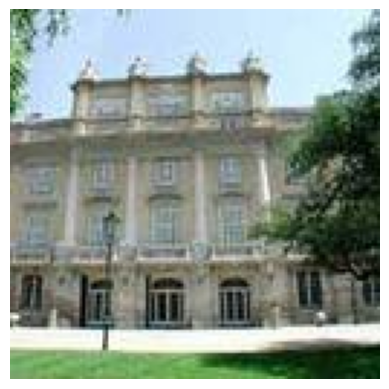

In [ ]:
#Visualizo las imagenes originales
#Cargo imagen para ver como esta
example_image_path = image_paths[2]
example_image = cv2.imread(example_image_path)

#convierto de BGR a RGB
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

#mostrar la imagen
plt.imshow(example_image)
plt.axis('off')
plt.show()

In [ ]:
#Verifico las dimensiones de varias imagenes
for path in image_paths[:5]:
  img = cv2.imread(path)
  print(f'Ruta:{path}, Dimensiones:{img.shape}')

Ruta:/content/drive/MyDrive/DeepLearning/proyecto/data_main/bbe4b672-340d-469b-9a0e-c1b867de7582/main.jpg, Dimensiones:(128, 128, 3)
Ruta:/content/drive/MyDrive/DeepLearning/proyecto/data_main/fa0f280f-22dd-441c-b2f0-5a7aaf912e8c/main.jpg, Dimensiones:(128, 128, 3)
Ruta:/content/drive/MyDrive/DeepLearning/proyecto/data_main/01efb07c-34cb-489b-8078-e1e3fb9c5407/main.jpg, Dimensiones:(128, 128, 3)
Ruta:/content/drive/MyDrive/DeepLearning/proyecto/data_main/59946ead-2409-45d2-a90e-24686f47de79/main.jpg, Dimensiones:(128, 128, 3)
Ruta:/content/drive/MyDrive/DeepLearning/proyecto/data_main/7634c9d0-60ba-4dca-8fd3-3d5e440cab1b/main.jpg, Dimensiones:(128, 128, 3)


In [ ]:
#Redimensionar y normalizar las imagenes
def load_and_preprocess_imagenes(image_path, target_size=(224,224)):
  images = []
  all_pixels = []

  for path in image_paths:
    #leo imagen
    img = cv2.imread(path)
    #Convertir de BGR a RGB
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #Redimensiono la imagen
    img =  cv2.resize(img, target_size) #224*224 pixeles
    #Normalizo
    img = img / 255.0
    #Añado la imagen procesada a la lista
    images.append(img)
    all_pixels.append(img)

  #Convierto la lista de imagenes a numpy
  all_pixels = np.array(all_pixels)

  #Calcula la media y std , solo con el conjunto de entrenamiento
  mean = all_pixels.mean(axis=(0, 1, 2))
  std = all_pixels.std(axis=(0, 1, 2))

  #Convierto la lista de imagenes en un array de numpy
  images = np.array(images)

  return images, mean, std




In [ ]:
#filtramos las rutas de imagenes a cada conjunto de datos
train_image_paths = [os.path.join(data_main_path, f'{id_}/main.jpg') for id_ in X_train_final['id']]
val_image_paths = [os.path.join(data_main_path, f'{id_}/main.jpg') for id_ in X_val['id']]
test_image_paths = [os.path.join(data_main_path, f'{id_}/main.jpg') for id_ in X_test['id']]

#verifico las rutas
print(train_image_paths[:5])

['/content/drive/MyDrive/DeepLearning/proyecto/data_main/d93ed9c7-1af5-4054-b518-5fd5f9575ffc/main.jpg', '/content/drive/MyDrive/DeepLearning/proyecto/data_main/ed0b1593-0656-4528-b34c-e30c7b0371e1/main.jpg', '/content/drive/MyDrive/DeepLearning/proyecto/data_main/060c7567-ef4a-4f09-9607-a4e3c2d4ad5c/main.jpg', '/content/drive/MyDrive/DeepLearning/proyecto/data_main/2ae8b853-327c-4dfa-b759-3b4bdba5d69f/main.jpg', '/content/drive/MyDrive/DeepLearning/proyecto/data_main/843f091d-428e-41a2-b6b8-bba14520d41a/main.jpg']


In [ ]:
X_train_images, mean, std = load_and_preprocess_imagenes(train_image_paths)

#verifico el tamaño de las imagenes cargadas y la media y sdt

print(X_train_images.shape)
print(f'Media:{mean}')
print(f'Desviacion estandar:{std}')

(1492, 224, 224, 3)
Media:[0.4547412  0.45057796 0.43063875]
Desviacion estandar:[0.26501494 0.26189898 0.27443988]


In [ ]:
# Antes de hacer las transformaciones, verifico las dimensiones de una imagen
sample_image = Image.open(train_image_paths[0]).convert('RGB')
print(f"Tamaño de la imagen de ejemplo: {sample_image.size}")  # Debería ser algo como (128, 128)


Tamaño de la imagen de ejemplo: (128, 128)


In [ ]:
#Definir las transformaciones para el conjunto de netrenamiento, con Data Augmentation
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean , std=std)
  ])
#para validacion y test, solo normalizamos sin augmentacion
transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean , std=std)
])

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Creo la clase personalizada Dataset
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

        #Verifico que los indices sean consistentes
        assert len(self.image_paths) == len(self.labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')  # Me aseguro de abrir como RGB
        label = self.labels.iloc[idx]



        if self.transform:
            img = self.transform(img)

        return img, label

# Crear datasets personalizados para entrenamiento, validación y test
train_dataset = CustomDataset(train_image_paths, y_train_final, transform=transform_train)
val_dataset = CustomDataset(val_image_paths, y_val, transform=transform_test)
test_dataset = CustomDataset(test_image_paths, y_test, transform=transform_test)

# Crear DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Imprimir tamaños de los datasets
#print(f"Tamaño del conjunto de entrenamiento: {len(train_loader.dataset)}")
#print(f"Tamaño del conjunto de validación: {len(val_loader.dataset)}")
#print(f"Tamaño del conjunto de test: {len(test_loader.dataset)}")


Tamaño del conjunto de entrenamiento: 1004
Tamaño del conjunto de validación: 251
Tamaño del conjunto de test: 314


In [ ]:
class SimpleMultimodalModel(nn.Module):
    def __init__(self, input_dim_fc, num_classes):
        super(SimpleMultimodalModel, self).__init__()

        # Red convolucional para procesar las imágenes
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Conv1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Pool1

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Conv2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Pool2

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Conv3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Pool3

            nn.Flatten(),
            nn.Linear(128*28*28, 128),  # Reduzco el tamaño de salida a 128
        )

        # Calculo el tamaño de la salida de la CNN para las imágenes de entrada 224x224
        self.cnn_output_size = 128  # La salida aplanada de la CNN tiene 128 características

        # Capas completamente conectadas para los metadatos
        self.fc_metadata = nn.Sequential(
            nn.Linear(input_dim_fc, 128),  # Suponiendo que `input_dim_fc` es el tamaño de los metadatos
            nn.ReLU()
        )

        # Capa completamente conectada para la salida final
        # La entrada de la capa final será la combinación de la salida de la CNN (128) y los metadatos (128)
        self.fc = nn.Linear(self.cnn_output_size + 128, num_classes)  # Ajustamos el tamaño a 256

    def forward(self, images, metadata):
        # Procesar las imágenes
        x = self.cnn(images)

        x = torch.flatten(x, 1)  # Aplana la salida de la CNN


        # Procesar los metadatos
        metadata_out = self.fc_metadata(metadata)

        # Concatenar la salida de la CNN con los metadatos
        x = torch.cat((x, metadata_out), dim=1)


        # Pasar por la capa final
        x = self.fc(x)
        return x


In [ ]:
#Configuracion del DataLoader

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Inicializa el modelo con el tamaño de entrada para los metadatos (input_dim_fc) y el número de clases (num_classes)
input_dim_fc = len(X_train_final.columns)  # El número de características de los metadatos

labels = []
for idx, (images, lbls) in enumerate(train_loader):  # Reemplaza 'train_loader' con tu propio DataLoader
    labels.append(lbls)

# Aplanamos las etiquetas para obtener el valor máximo
labels = torch.cat(labels, dim=0)  # Concatenamos las etiquetas de todos los batches
num_classes = int(labels.max().item()) + 1  # Calculamos el número de clases (sumamos 1)
print(f'Número de clases: {num_classes}')
model = SimpleMultimodalModel(input_dim_fc, num_classes).to(device)

# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Definir el dispositivo (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
labels=labels.to(device)

# Entrenamiento
epochs = 10
batch_size = 32  # Aseguramos que el tamaño del batch sea consistente

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    y_true = []  # Para almacenar etiquetas reales en clasificación
    y_pred = []  # Para almacenar predicciones del modelo

    for idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        # Mover las imágenes y las etiquetas al dispositivo
        images = images.to(device).float()
        labels = labels.to(device).long()  # Asegurarse que las etiquetas sean enteros (para clasificación)

        # Obtener las características del dataset para este batch
        batch_start = idx * batch_size
        batch_end = (idx + 1) * batch_size
        metadata_batch = X_train_final.iloc[batch_start:batch_end]

        # Convertir los metadatos a un DataFrame de pandas
        metadata_batch = pd.DataFrame(metadata_batch)

        # Convertir todas las columnas a valores numéricos, forzando errores a NaN
        metadata_batch = metadata_batch.apply(pd.to_numeric, errors='coerce')

        # Rellenar los NaN con 0 o algún valor que consideres adecuado
        metadata_batch = metadata_batch.fillna(0)

        # Convertir de nuevo a numpy ndarray
        metadata = torch.tensor(metadata_batch.values).float().to(device)

        # Asegurarnos de que el tamaño del batch de metadatos coincida con el tamaño de las imágenes
        assert metadata.shape[0] == images.shape[0], f"El tamaño del batch de metadatos ({metadata.shape[0]}) no coincide con el tamaño de las imágenes ({images.shape[0]})"

        # Hacer la predicción
        outputs = model(images, metadata)  # Esto devuelve los logits para cada clase

        # Calcular la pérdida
        loss = criterion(outputs, labels)  # CrossEntropyLoss espera etiquetas de tipo long (enteros)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Acumular la pérdida para ver el progreso
        running_loss += loss.item()

        # Almacenar las predicciones y las etiquetas
        y_true.append(labels.cpu().detach().numpy())
        _, predicted = torch.max(outputs, 1)  # Obtén la clase predicha
        y_pred.append(predicted.cpu().detach().numpy())

    # Calcular la pérdida promedio para el epoch
    avg_loss = running_loss / len(train_loader)

    # Concatenar todas las etiquetas y predicciones para calcular el accuracy
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    # Calcular la precisión
    accuracy = np.mean(y_true == y_pred)  # Calcular precisión
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


KeyboardInterrupt: 

In [ ]:
# Validación
model.eval()  # Cambio a modo de evaluación
running_loss = 0.0
y_true = []  # Para almacenar etiquetas reales en clasificación
y_pred = []  # Para almacenar predicciones del modelo

with torch.no_grad():  # No calcular gradientes durante la validación
    for idx, (images, labels) in enumerate(val_loader):
        # Mover las imágenes y las etiquetas al dispositivo
        images = images.to(device).float()
        labels = labels.to(device).long()  # Me aseguro que las etiquetas sean enteros

        # Obtener las características del dataset para este batch
        batch_start = idx * batch_size
        batch_end = (idx + 1) * batch_size
        metadata_batch = y_val.iloc[batch_start:batch_end]

        # Convertir los metadatos a un DataFrame de pandas
        metadata_batch = pd.DataFrame(metadata_batch)

        # Convertir todas las columnas a valores numéricos, forzando errores a NaN
        metadata_batch = metadata_batch.apply(pd.to_numeric, errors='coerce')

        # Rellenar los NaN con 0 o algún valor que consideres adecuado
        metadata_batch = metadata_batch.fillna(0)

        # Convertir de nuevo a numpy ndarray
        metadata = torch.tensor(metadata_batch.values).float().to(device)

        # Asegurar de que el tamaño del batch de metadatos coincida con el tamaño de las imágenes
        assert metadata.shape[0] == images.shape[0], f"El tamaño del batch de metadatos ({metadata.shape[0]}) no coincide con el tamaño de las imágenes ({images.shape[0]})"

        # Hacer la predicción
        outputs = model(images, metadata)

        # Calcular la pérdida
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Almacenar las predicciones y las etiquetas
        y_true.append(labels.cpu().detach().numpy())
        _, predicted = torch.max(outputs, 1)  # Obtén la clase predicha
        y_pred.append(predicted.cpu().detach().numpy())

    # Aquí debería estar fuera del bucle "for", pero con la indentación correcta
    val_loss = running_loss / len(val_loader)

    # Concatenar todas las etiquetas y predicciones para calcular el accuracy
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    # Calcular precisión en validación
    val_accuracy = np.mean(y_true == y_pred)
    print(f"Validación - Epoch [{epoch+1}/{epochs}], Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")


    # Concatenar todas las etiquetas y predicciones para calcular el accuracy
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    # Calcular precisión en validación
    val_accuracy = np.mean(y_true == y_pred)
    print(f"Validación - Epoch [{epoch+1}/{epochs}], Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1 and 233x128)

In [ ]:
# Prueba después de completar el entrenamiento
model.eval()  # Cambiar a modo de evaluación
running_loss = 0.0
y_true = []  # Para almacenar etiquetas reales en clasificación
y_pred = []  # Para almacenar predicciones del modelo

with torch.no_grad():  # No calcular gradientes durante la prueba
    for idx, (images, labels) in enumerate(test_loader):
        # Mover las imágenes y las etiquetas al dispositivo
        images = images.to(device).float()
        labels = labels.to(device).long()

        # Obtener las características del dataset para este batch
        batch_start = idx * batch_size
        batch_end = (idx + 1) * batch_size
        metadata_batch = y_text.iloc[batch_start:batch_end]

        # Convertir los metadatos a un DataFrame de pandas
        metadata_batch = pd.DataFrame(metadata_batch)

        # Convertir todas las columnas a valores numéricos, forzando errores a NaN
        metadata_batch = metadata_batch.apply(pd.to_numeric, errors='coerce')

        # Rellenar los NaN con 0 o algún valor que consideres adecuado
        metadata_batch = metadata_batch.fillna(0)

        # Convertir de nuevo a numpy ndarray
        metadata = torch.tensor(metadata_batch.values).float().to(device)

        # Asegurarnos de que el tamaño del batch de metadatos coincida con el tamaño de las imágenes
        assert metadata.shape[0] == images.shape[0], f"El tamaño del batch de metadatos ({metadata.shape[0]}) no coincide con el tamaño de las imágenes ({images.shape[0]})"

        # Hacer la predicción
        outputs = model(images, metadata)

        # Calcular la pérdida
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Almacenar las predicciones y las etiquetas
        y_true.append(labels.cpu().detach().numpy())
        _, predicted = torch.max(outputs, 1)  # Obtén la clase predicha
        y_pred.append(predicted.cpu().detach().numpy())

# Calcular la pérdida promedio para la prueba
test_loss = running_loss / len(test_loader)

# Concatenar todas las etiquetas y predicciones para calcular el accuracy
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

# Calcular precisión en test
test_accuracy = np.mean(y_true == y_pred)
print(f"Prueba - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

NameError: name 'X_test_final' is not defined